# Yarden's Part - SARIMA

## Basic Set Up

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## EDA

In [105]:
data = pd.read_csv('data_final/combined_data.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head(10)

,Close,Crude Oil Price,Jet Fuel Price,Revenue,Net Income,S&P 500,set
Date,,,,,,,
2014-07-01,1.000000,110.84,2.858,11352.652174,864.847826,1.000000,train
2014-07-02,0.956452,110.18,2.830,11350.304348,865.695652,1.000659,train
2014-07-03,0.948928,108.98,2.817,11347.956522,866.543478,1.006142,train
2014-07-07,0.914273,108.70,2.797,11338.565217,869.934783,1.002194,train
2014-07-08,0.917921,107.65,2.775,11336.217391,870.782609,0.995130,train
2014-07-09,0.957364,106.84,2.779,11333.869565,871.630435,0.999752,train
2014-07-10,0.976288,106.20,2.817,11331.521739,872.478261,0.995622,train
2014-07-11,0.977656,105.77,2.800,11329.173913,873.326087,0.997086,train
2014-07-14,0.979936,104.73,2.809,11322.130435,875.869565,1.001916,train


In [106]:
AAL = data['Close']
AAL.head(10)

Date
2014-07-01    1.000000
2014-07-02    0.956452
2014-07-03    0.948928
2014-07-07    0.914273
2014-07-08    0.917921
2014-07-09    0.957364
2014-07-10    0.976288
2014-07-11    0.977656
2014-07-14    0.979936
2014-07-15    0.996352
Name: Close, dtype: float64

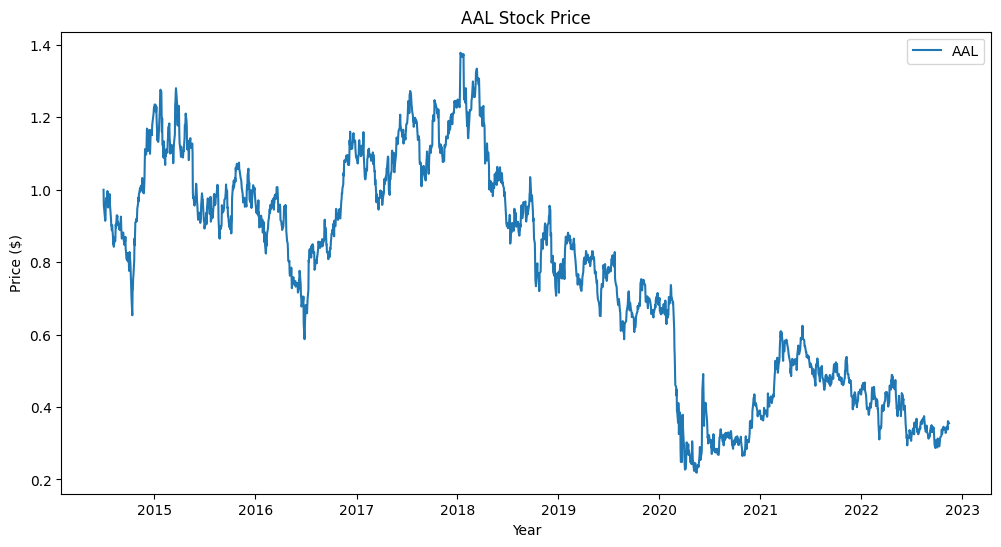

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(AAL)
plt.title('AAL Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend(['AAL'])
plt.show()

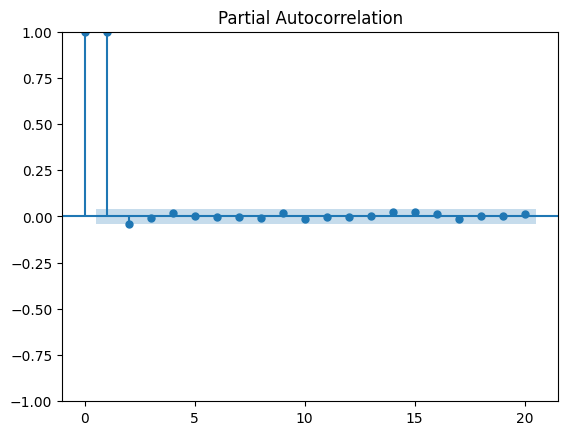

In [108]:
tsaplots.plot_pacf(AAL, lags=20);

In [109]:
AAL_diff = AAL.diff(periods=1).dropna()

As seen in the above graph, only the first term is non-zero. Therefore, we try differencing with $d=1$, i.e. we define the differenced series $Z_t = X_t - X_{t-1}$.

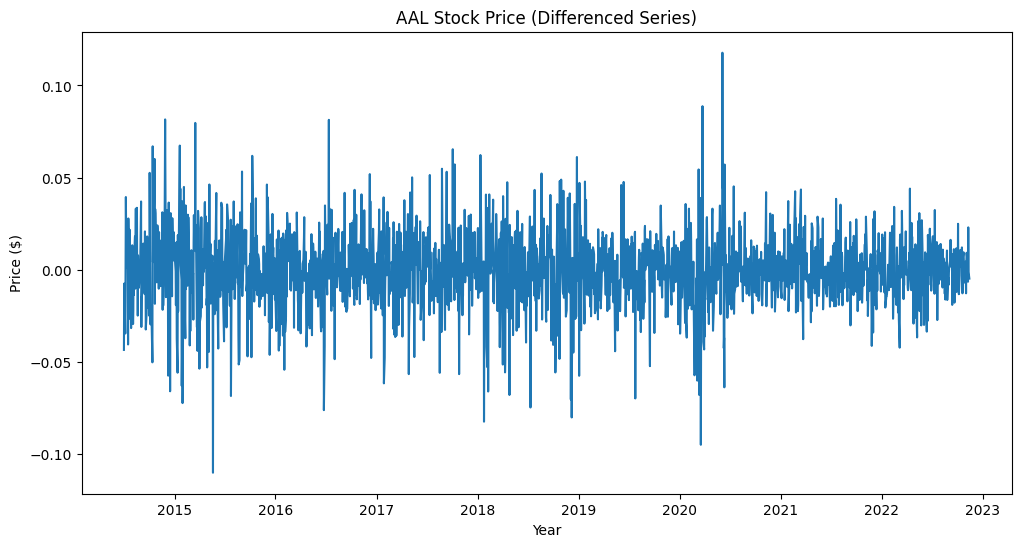

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(AAL_diff)
plt.title('AAL Stock Price (Differenced Series)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()

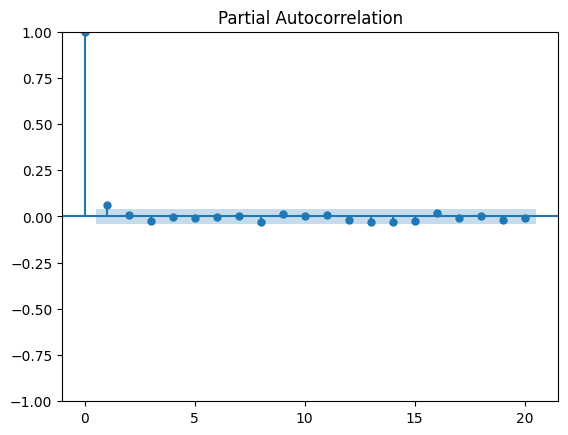

In [111]:
tsaplots.plot_pacf(AAL_diff, lags=20);

## SARIMA

### Dividing to Train, Validation and Test

In [112]:
train = AAL[data['set'] == 'train']
test = AAL[data['set'] == 'test']

In [113]:
def plot_predictions(train, test, predictions, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions', color='red')
    plt.title('AAL Stock Price Predictions ' + model)
    plt.xlabel('Year')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

### Fitting SARIMA Model

As seen in the EDA, the differenced series mitigates the trednd present in the original data. Therefore, we fit a SARIMA model to the differenced series.

In [139]:
auto_sarima_model = auto_arima(train, seasonal=True, m = 5,
                               d = 1, D = 1, 
                               start_p = 0, start_q = 0, max_p = 4, max_q = 4,
                               start_P = 0, start_Q = 0, max_P = 4, max_Q = 4,
                               trace=True, error_action='warn', suppress_warnings=True,
                               random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-5162.022, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-5522.214, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-5162.746, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-5652.341, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-5743.631, Time=0.90 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-5793.372, Time=1.21 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=-5910.463, Time=4.08 sec
 ARIMA(1,1,0)(3,1,1)[5]             : AIC=-5967.024, Time=2.77 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=3.37 sec
 ARIMA(1,1,0)(3,1,2)[5]             : AIC=inf, Time=4.46 sec
 ARIMA(1,1,0)(2,1,2)[5]             : AIC=inf, Time=3.65 sec
 ARIMA(1,1,0)(4,1,2)[5]             : AIC=inf, Time=6.87 sec
 ARIMA(0,1,0)(3,1,1)[5]             : AIC=inf, Time=2.66 sec
 ARIMA(2,1,0)(3,1,1)[5]             : AIC=-5960.649, Ti

In [140]:
AAL_model = SARIMAX(train, order=auto_sarima_model.order, seasonal_order=auto_sarima_model.seasonal_order)
AAL_fit = AAL_model.fit(disp=False)
AAL_pred = AAL_fit.get_forecast(steps=len(test))
print(AAL_fit.summary())

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1266
Model:             SARIMAX(1, 1, 0)x(3, 1, [1], 5)   Log Likelihood                2989.512
Date:                             Sun, 10 Nov 2024   AIC                          -5967.024
Time:                                     15:28:28   BIC                          -5936.190
Sample:                                          0   HQIC                         -5955.437
                                            - 1266                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1634      0.026      6.231      0.000       0.112       0.215
ar.S.L5       -0.0094      

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


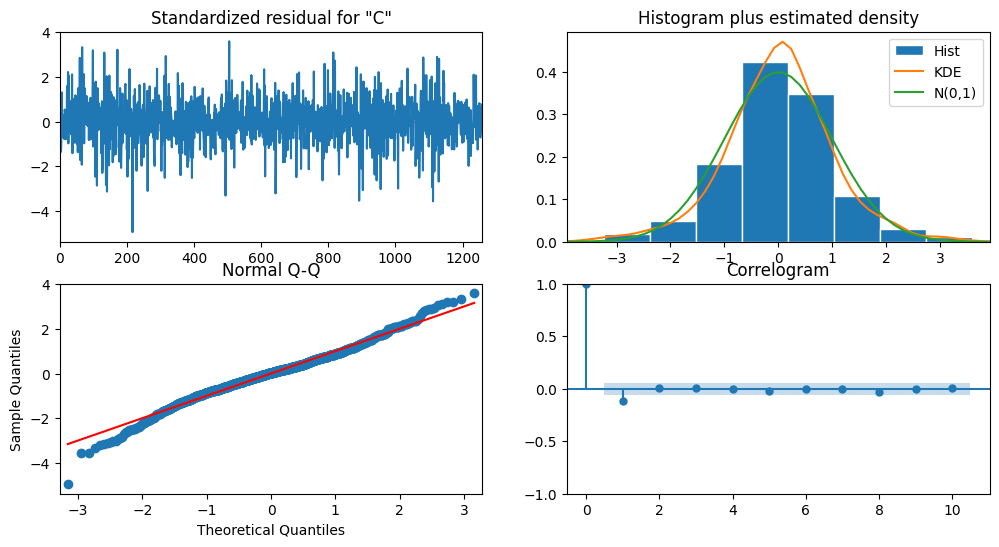

In [142]:
AAL_fit.plot_diagnostics(figsize=(12, 6));

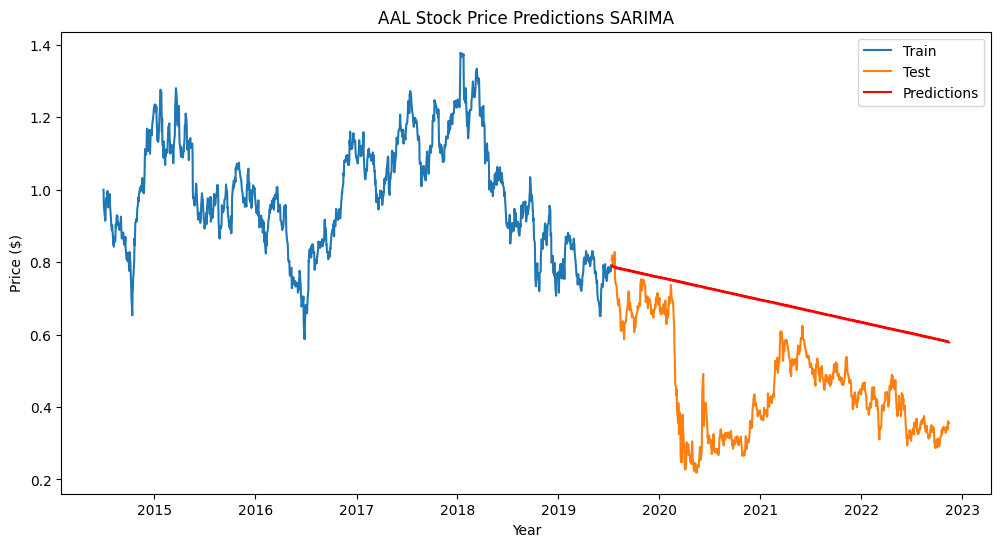

In [143]:
AAL_pred_indexed = AAL_pred.predicted_mean
AAL_pred_indexed.index = test.index
plot_predictions(train, test, AAL_pred_indexed, 'SARIMA')

## One Day Ahead SARIMA

### RMSE

In [147]:
def calc_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

In [157]:
# Create a copy of the original training data
extended_train = train.copy()
oda_pred = pd.Series([])

for test_index, test_point in test.items():
    # Get a one-step forecast using the fitted model
    forecast = AAL_fit_copy.get_forecast(steps=1)
    forecast_mean = forecast.predicted_mean.iloc[0]  # Extract the forecasted value

    # Store the forecasted value
    oda_pred.at[test_index] = forecast_mean

    # Append the new test point to the extended training data
    extended_train.at[test_index] = test_point

    # Refit the model with the extended data
    AAL_fit_copy = SARIMAX(extended_train, order=AAL_fit_copy.model.order, seasonal_order=AAL_fit_copy.model.seasonal_order).fit(disp=False)

# Print or plot the predictions
print(oda_pred)


/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

2019-07-12    0.790772
2019-07-15    0.809813
2019-07-16    0.803383
2019-07-17    0.820532
2019-07-18    0.796140
                ...   
2022-11-08    0.348177
2022-11-09    0.345514
2022-11-10    0.337488
2022-11-11    0.359436
2022-11-14    0.358059
Length: 844, dtype: float64


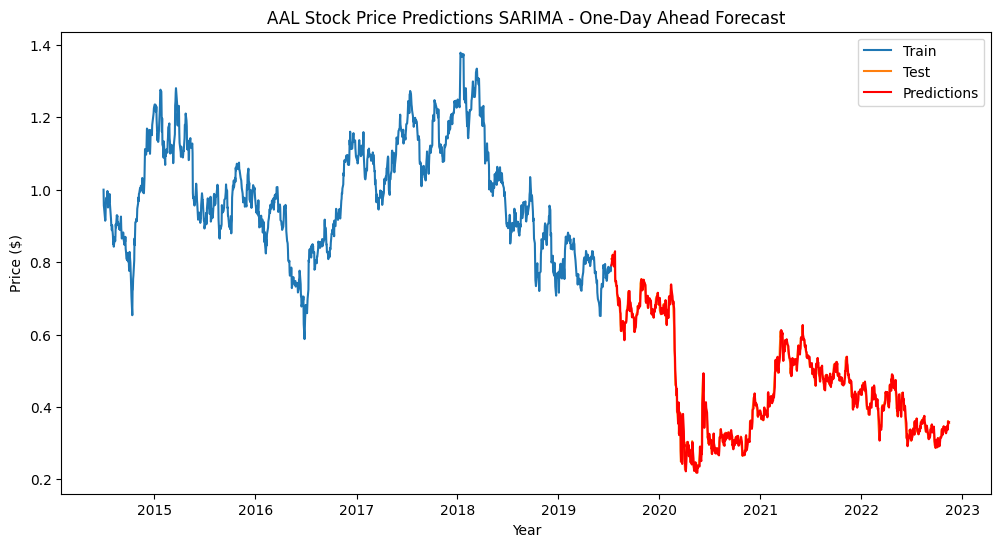

In [158]:
plot_predictions(train, test, oda_pred, 'SARIMA - One-Day Ahead Forecast')

In [160]:
rmse_oda = calc_rmse(test, oda_pred)
print(f'RMSE of One-Day Ahead Forecast: {rmse_oda}')

RMSE of One-Day Ahead Forecast: 0.017142554106519586


## Five Days Ahead SARIMA

In [164]:
# Create a copy of the original training data
extended_train = train.copy()
fda_pred = pd.Series([])

# Predict in 5-day chunks
for test_index in range(len(test) // 5):
    # Get a 5-step forecast using the fitted model
    forecast = AAL_fit_copy.get_forecast(steps=5)
    forecast_mean = forecast.predicted_mean  # Extract the forecasted values

    # Store the forecasted values for the next 5 days
    for i, value in enumerate(forecast_mean):
        fda_pred.at[test.index[test_index * 5 + i]] = value

    # Append the new test points to the extended training data
    new_data_points = test[test.index[test_index * 5: test_index * 5 + 5]]
    extended_train = pd.concat([extended_train, new_data_points])
    
    # Refit the model with the extended data
    AAL_fit_copy = SARIMAX(
        extended_train, 
        order=AAL_fit_copy.model.order, 
        seasonal_order=AAL_fit_copy.model.seasonal_order
    ).fit(disp=False)

# Handle remaining points (if any)
remaining_points = len(test) % 5
if remaining_points > 0:
    forecast = AAL_fit_copy.get_forecast(steps=remaining_points)
    forecast_mean = forecast.predicted_mean  # Extract the forecasted values

    # Store the forecasted values for the remaining points
    for i, value in enumerate(forecast_mean):
        fda_pred.at[test.index[-remaining_points + i]] = value

# Print or plot the predictions
print(fda_pred)

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

2019-07-12    0.355843
2019-07-15    0.356134
2019-07-16    0.356267
2019-07-17    0.354791
2019-07-18    0.352936
                ...   
2022-11-08    0.335564
2022-11-09    0.345514
2022-11-10    0.345668
2022-11-11    0.343088
2022-11-14    0.341124
Length: 844, dtype: float64


/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


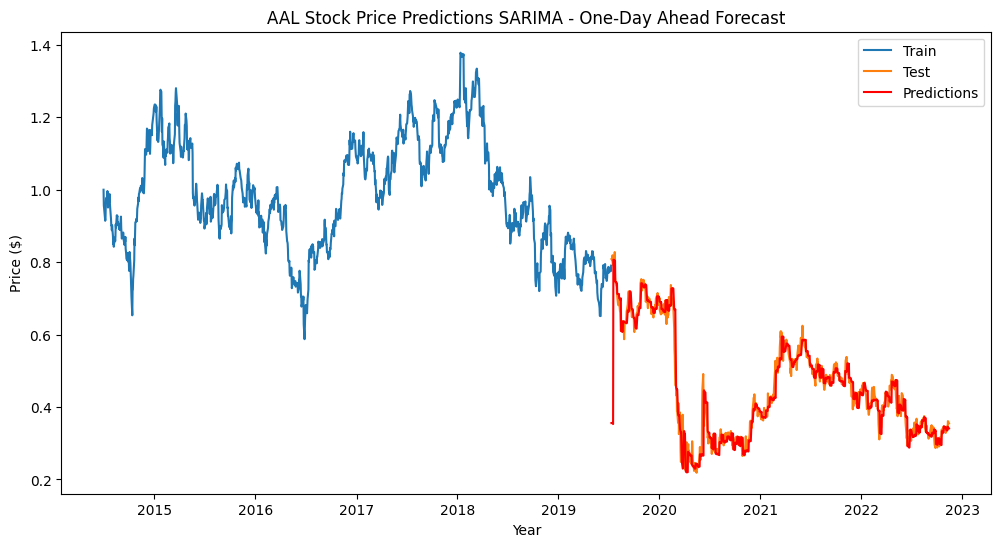

In [165]:
plot_predictions(train, test, fda_pred, 'SARIMA - One-Day Ahead Forecast')

In [166]:
rmse_fda = calc_rmse(test, fda_pred)
print(f'RMSE of One-Day Ahead Forecast: {rmse_fda}')

RMSE of One-Day Ahead Forecast: 0.04746365803474313
